# Are Rosetta's range rate oscillations also explained by tracking signal lag?

Range rate residual oscillations similar to those of NEAR's post-encounter Doppler were reported for Rosetta's 2005 Earth flyby, which also had an anomalous $\Delta v$ [2].

They are similarly reproduced below by simulation of light-time lags in the tracking signal. They incidentally vanish if the initial state for the orbital elements is taken 3 or more days before perigee, as the initial lag is then too small to inflict a significant change at and through the perigee.

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, esNewNorcia
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory, find_swings

solar_system_ephemeris.set("de440")
rosetta_start = Tracking.ROSETTA05_PERIGEE.value - 2.99985*u.day
#rosetta_start = Tracking.ROSETTA05_PERIGEE.value - 4.5*u.day
rosetta_end = Tracking.ROSETTA05_PERIGEE.value + 30*u.day

In [2]:
sampling_interval = 1800
sample_offsets = np.arange(0, (rosetta_end-rosetta_start)/(1*u.s), sampling_interval)
flyby_epochs = rosetta_start + (sample_offsets << u.s)
print("Start and end epochs:", flyby_epochs[0], flyby_epochs[-1], "[", flyby_epochs.size, "]")

Start and end epochs: 2005-03-01 22:09:26.960 2005-04-03 21:39:26.960 [ 1584 ]


In [3]:
rosetta_reference_ephem = Ephem.from_horizons("Rosetta", rosetta_start, attractor=Earth, plane=Planes.EARTH_EQUATOR)
rosetta_reference_start_rv = rosetta_reference_ephem.rv(rosetta_start)
describe_state(rosetta_reference_start_rv, dss25, rosetta_start)


:AT: 2005-03-01 22:09:26.960
Geocentric distance: 1086443.8366925984 km speed: 3.9631090784735874 km / s
From Goldstone-25 : range  1090843.1797361549 km , range rate  -4.145085113713824 km / s


In [4]:
rosetta_reference_orbit = Orbit.from_vectors(Earth, rosetta_reference_start_rv[0], rosetta_reference_start_rv[1], rosetta_start)
describe_orbit(rosetta_reference_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 144.77452063063163 deg
Eccentricity: 1.2826206467183427
Semilatus rectum: 17174.423356022406 km
Semimajor axix: -26622.236497076028 km
Periapse radius: 7523.993695892294 km , altitude: 1145.8570958922946 km


In [5]:
rosetta_extended_ephem = rosetta_reference_orbit.to_ephem(EpochsArray(flyby_epochs))
describe_trajectory(rosetta_extended_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 1083343.2739441176 km 10173900.891009295 km
Start and end radial speeds: -4.145085113713796 km / s 3.991537730116549 km / s
Closest: 5483.26813993285 km speed 10.555023031845788 km / s  at  2005-03-04 22:09:26.960
Deflection: 102.44444152885428 deg


In [6]:
sim_meas_newnorcia = []

for e in flyby_epochs:
    rv = rosetta_extended_ephem.rv(e)
    ref_r, ref_rr, ref_ra = esNewNorcia.range_rate_accel(rv, e)
    sim_meas_newnorcia.append([ref_rr - ref_ra*ref_r/const.c])

#print(sim_meas_newnorcia)

In [7]:
from sim.fitorbit import OrbitFitter
fitter = OrbitFitter(rosetta_reference_orbit, [esNewNorcia], var=0.001, debug=True)

Range constraints:
a: -26595614.260578953 -26648858.7335731
ecc: 1.2813380260716245 1.283903267365061
inc: 2.5242652659429785 2.52931885005898


In [8]:
from datetime import datetime 
start_time = datetime.now()
#print(start_time)

In [9]:
fitter.fit_doppler_data(flyby_epochs, sim_meas_newnorcia)
time_elapsed = datetime.now() - start_time
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

-1. 0.218240 {'a': -26622236.497076027, 'ecc': 1.2826206467183427, 'inc': 2.5267920580009795, 'nu': -2.445461823572489, 'raan': 2.968902159850828, 'argp': 2.5254272474034316}
0. 0.218240 {'a': -26622236.497076027, 'ecc': 1.2826206467183427, 'inc': 2.5267920580009795, 'nu': -2.445461823572489, 'raan': 2.968902159850828, 'argp': 2.5254272474034316}
1. 0.218240 {'a': -26622236.497076027, 'ecc': 1.2826206467183427, 'inc': 2.5267920580009795, 'nu': -2.445461823572489, 'raan': 2.968902159850828, 'argp': 2.5254272474034316}
2. 0.218223 {'a': -26622236.496679325, 'ecc': 1.2826206467183427, 'inc': 2.5267920580009795, 'nu': -2.445461823572489, 'raan': 2.968902159850828, 'argp': 2.5254272474034316}
3. 0.219073 {'a': -26622236.497076027, 'ecc': 1.2826206467374552, 'inc': 2.5267920580009795, 'nu': -2.445461823572489, 'raan': 2.968902159850828, 'argp': 2.5254272474034316}
4. 0.218240 {'a': -26622236.497076027, 'ecc': 1.2826206467183427, 'inc': 2.5267920580009795, 'nu': -2.445461823572489, 'raan': 2.

In [10]:
describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 144.77452063063163 deg
Eccentricity: 1.2826204779162498
Semilatus rectum: 17174409.00342524 m
Semimajor axix: -26622232.11849794 m
Periapse radius: 7523987.964527223 m , altitude: 1145851.3645272236 m

::TRAJECTORY::
Start and end ranges: 1083343.243541288 km 10173901.81584824 km
Start and end radial speeds: -4.14508675736395 km / s 3.991537558056338 km / s
Closest: 5483.524454291385 km speed 10.554972479206988 km / s  at  2005-03-04 22:09:26.960
Deflection: 102.44446031323021 deg


In [11]:
print(fitter.result.residual)

[-0.00123606 -0.00144613 -0.0016576  ...  0.00048871  0.00042782
  0.00036276]


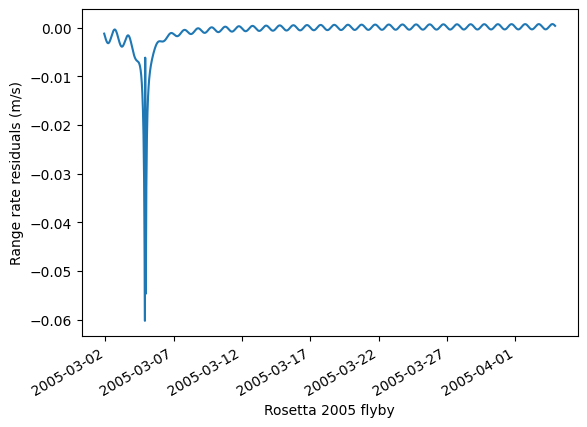

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy import visualization
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('Rosetta 2005 flyby')
    plt.ylabel('Range rate residuals (m/s)')
    plt.plot(flyby_epochs, fitter.result.residual)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.gcf().autofmt_xdate()

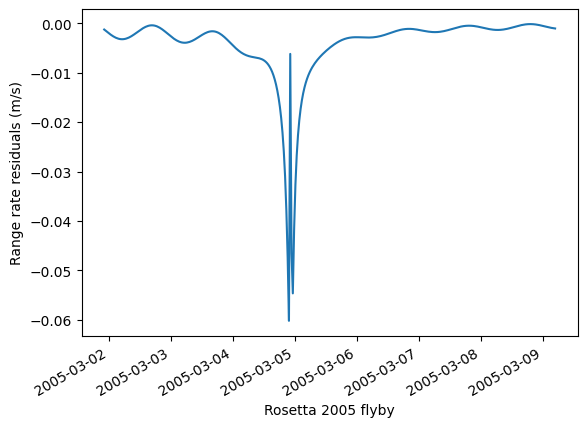

In [13]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('Rosetta 2005 flyby')
    plt.ylabel('Range rate residuals (m/s)')
    plt.plot(flyby_epochs[:350], fitter.result.residual[:350])
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gcf().autofmt_xdate()

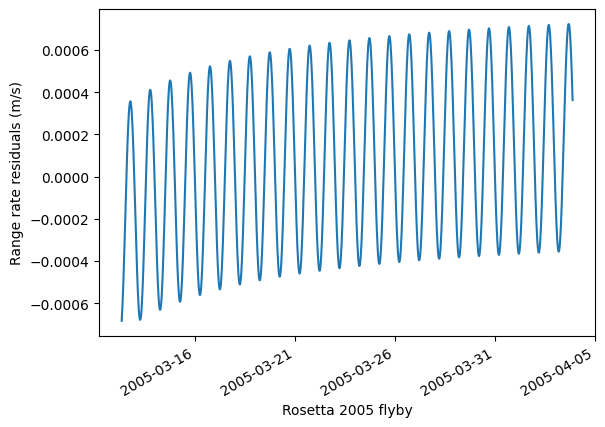

In [14]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('Rosetta 2005 flyby')
    plt.ylabel('Range rate residuals (m/s)')
    plt.plot(flyby_epochs[500:], fitter.result.residual[500:])
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.gcf().autofmt_xdate()

['2005-03-02 16:39:26.960' '2005-03-03 05:09:26.960'
 '2005-03-03 16:09:26.960' '2005-03-04 21:39:26.960'
 '2005-03-04 22:09:26.960' '2005-03-04 23:09:26.960'
 '2005-03-05 23:39:26.960' '2005-03-06 04:09:26.960'
 '2005-03-06 20:09:26.960' '2005-03-07 06:09:26.960'
 '2005-03-07 19:09:26.960' '2005-03-08 06:39:26.960'
 '2005-03-08 19:09:26.960' '2005-03-09 06:39:26.960'
 '2005-03-09 18:39:26.960' '2005-03-10 06:39:26.960'
 '2005-03-10 18:39:26.960' '2005-03-11 06:39:26.960'
 '2005-03-11 18:39:26.960' '2005-03-12 06:09:26.960'
 '2005-03-12 18:39:26.960' '2005-03-13 06:09:26.960'
 '2005-03-13 18:39:26.960' '2005-03-14 06:09:26.960'
 '2005-03-14 18:09:26.960' '2005-03-15 06:09:26.960'
 '2005-03-15 18:09:26.960' '2005-03-16 06:09:26.960'
 '2005-03-16 18:09:26.960' '2005-03-17 06:09:26.960'
 '2005-03-17 18:09:26.960' '2005-03-18 06:09:26.960'
 '2005-03-18 18:09:26.960' '2005-03-19 06:09:26.960'
 '2005-03-19 18:09:26.960' '2005-03-20 05:39:26.960'
 '2005-03-20 17:39:26.960' '2005-03-21 05:39:2

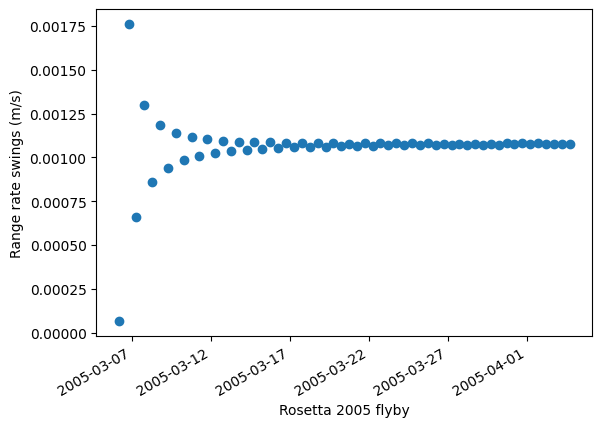

In [15]:
peak_epochs, peak_swings = find_swings(flyby_epochs, fitter.result.residual)
print(peak_epochs, peak_swings)
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('Rosetta 2005 flyby')
    plt.ylabel('Range rate swings (m/s)')
    plt.scatter(peak_epochs[7:], peak_swings[7:])
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.gcf().autofmt_xdate()